## House Price

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [225]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [230]:
from functools import partial

In [118]:
pip install hyperopt

In [4]:
TRAIN_DATASET_PATH = '/data/train.csv' # y_train, y_valid
TEST_DATASET_PATH = '/data/test.csv'

In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
df.head(5) 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим пропуски в LifeSquare и Healthcare_1. Видим буквенные категории в Ecology_2, Ecology_3, Shops_2 - будем разбираться в следующем разделе.

### Предобработка данных
####  Преобразования категориальных переменных в числовые

##### Ecology_2, Ecology_2, Ecology_3, Shops_2 

In [7]:
df.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [8]:
print(df.loc[df['Ecology_2']=='B', 'Price'].mean())
print(df.loc[df['Ecology_2']=='A', 'Price'].mean())

214344.5442227426
193139.71700581786


<AxesSubplot:>

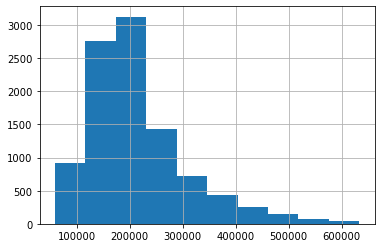

In [9]:
df.loc[df['Ecology_2']=='B', 'Price'].hist()

<AxesSubplot:>

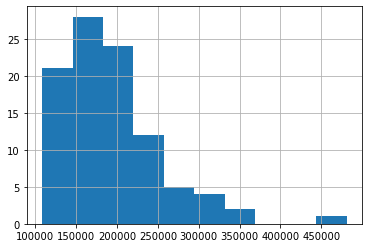

In [10]:
df.loc[df['Ecology_2']=='A', 'Price'].hist()

Редкий, но судя по всему, очень значительный признак. Применим к нему 

In [11]:
df.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [12]:
df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [13]:
df = pd.get_dummies(df, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

### Числовые признаки
#### Id
Id не значимый признак, поэтому выбрасываем их. Но запишим их в свою таблицу для выходного файла.

In [14]:
df.drop('Id', axis=1, inplace=True)
test_id = test['Id']
test.drop('Id', axis=1, inplace=True)

#### Мультиколлинеарность 

In [21]:
cm = sns.light_palette("green", as_cmap=True)
s = pd.DataFrame(df[df.columns[~df.columns.isin(['DistrictId'])]].corr()).style.background_gradient(cmap=cm)
s

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B
Rooms,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291,-0.001971,-0.005909,-0.000146
Square,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075,0.029926,0.022748,-0.049380
LifeSquare,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292,0.006808,0.008597,-0.004692
KitchenSquare,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864,0.000268,-0.007919,-0.017315
Floor,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715,0.049661,0.025767,-0.013626
HouseFloor,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280,0.059347,0.009258,0.051002
HouseYear,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305,0.000997,0.001686,0.002994
Ecology_1,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381,-0.110725,-0.223197,0.079809
Social_1,0.075980,-0.070690,-0.048363,0.043379,-0.044914,-0.020801,0.003026,0.026464,1.000000,0.955988,0.023721,0.077133,0.524593,0.526272,0.263286,-0.066017,-0.037777,0.144644
Social_2,0.071335,-0.043120,-0.039283,0.037805,-0.016560,0.007194,0.001970,0.009264,0.955988,1.000000,0.073379,0.050458,0.473193,0.559163,0.239226,-0.012709,0.007394,0.143777


#### Social_1 и Social_2
Так как эти признаки между собой очень сильно коррелируют, то удалим Social_1 (мне больше он не нравится, так как имеет чуть более сильную корреляцию с другими признаками).

In [143]:
df.drop('Social_1', axis=1, inplace=True)
test.drop('Social_1', axis=1, inplace=True)

#### HouseYear

Посмотрим на разнообразие года постройки

In [144]:
df.HouseYear.value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [145]:
df.loc[((df['HouseYear']>df['HouseYear'].quantile(.999))|(df['HouseYear']<df['HouseYear'].quantile(.001)))]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B
910,172,2.0,56.172364,28.384213,7.0,8,6.0,1914,0.000000,1660,39,1786.0,1,5,423580.477982,1,1,1
1380,195,3.0,75.564709,44.872616,9.0,5,7.0,1917,0.015017,3079,59,2890.0,0,8,486057.129888,1,1,1
1497,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,6141,10,262.0,3,6,254084.534396,1,1,1
2656,183,4.0,151.150660,98.187482,23.0,6,7.0,1912,0.037316,6748,93,562.0,4,10,284884.959104,1,1,1
4189,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,4756,16,2857.0,5,8,243028.603096,1,1,1
5053,104,1.0,35.507738,20.312725,4.0,6,5.0,1917,0.000078,6398,141,1046.0,3,23,236830.764637,1,1,1
5111,161,1.0,63.293079,29.389815,18.0,3,9.0,1912,0.014423,3806,4,NaN,0,3,262279.813915,1,1,1
7611,183,3.0,102.964468,48.322107,14.0,4,6.0,1916,0.037316,6748,93,562.0,4,10,284608.939261,1,1,1
8144,189,2.0,54.751367,31.515082,10.0,2,4.0,1917,0.000078,6398,141,1046.0,3,23,69623.753191,1,1,1
9317,161,1.0,50.808925,15.920343,20.0,8,9.0,1910,0.014423,3806,4,NaN,0,3,287954.720682,1,1,1


In [146]:
df.loc[df['HouseYear']==20052011, 'HouseYear'] = 2011
df['HouseYear'].quantile(.999)

2020.0

Видим, что абсолютное большинство датированно 2020 годом, все что младше заполню модой (кроме ошибочного значения 20052011 - его считаю ошибочным и присваиваю дату 2011 - считаю, что взяли годы постройки).

In [147]:
stats.mode(df['HouseYear'])[0][0]

1977

<AxesSubplot:>

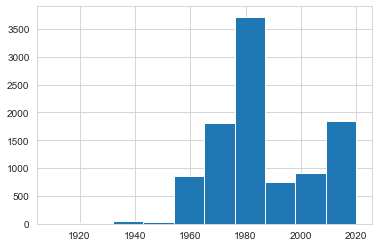

In [148]:
df.loc[df['HouseYear']>2020,'HouseYear'] = stats.mode(df['HouseYear'])[0][0]
test.loc[test['HouseYear']>2020,'HouseYear'] = stats.mode(df['HouseYear'])[0][0]
df['HouseYear'].hist()

#### Описание данных

In [149]:
df[['Rooms', 'Square', 'LifeSquare','KitchenSquare', 'Floor','HouseFloor', 'Price', 'Healthcare_1']].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Price,Healthcare_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,214138.857399,1142.904460
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,92872.293865,1021.517264
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,153872.633942,350.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,192269.644879,900.000000
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,249135.462171,1548.000000
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,633233.466570,4849.000000


#### Rooms + построение нового признака на основе Square / Rooms

In [150]:
df.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [151]:
df['Square_Room'] = df.loc[df['Rooms']!=0, 'Square'] / df.loc[df['Rooms']!=0, 'Rooms']
prop_m = df['Square_Room'].mean()
prop_m

32.497944815517855

In [152]:
df.loc[df['Rooms']==19]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1454,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,264,0,NaN,0,1,78364.616704,1,1,1,2.210845


время делить где то тут. Я начинаю дропать.

In [153]:
df.loc[df['Rooms']==19, 'Rooms'] = 1
df.loc[df['Rooms']==0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1397,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,3097,0,NaN,0,0,268394.744389,1,1,1,NaN
1981,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,NaN
2269,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,1892,0,NaN,0,1,98129.976788,1,1,1,NaN
3911,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,6207,1,1183.0,1,0,217009.338463,1,1,1,NaN
4366,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,1564,0,540.0,0,0,212864.799112,1,1,1,NaN
4853,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,469,0,NaN,0,0,126596.941798,1,1,1,NaN
6149,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,8429,3,NaN,3,9,158998.110646,1,1,1,NaN
8834,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,1892,0,NaN,0,1,219281.918007,1,1,1,NaN


4853 позиция вообще странная, её удаляю. 6149 и 2269 тоже - они среднии по площади, но ниже среднего по цене. Остальные заполню так - если меньше среднего по площади - то 2, если больше - 3.

In [154]:
df = df.drop(4853)
df = df.drop(6149)
df = df.drop(2269)
df.loc[df['Rooms']==0,'Rooms'] = df.loc[df['Rooms']==0,'Square'] // prop_m

In [155]:
df.loc[df['Rooms']==0,'Rooms'] = df.loc[df['Rooms']==0,'Square'] // prop_m

In [156]:
prop_05 = df['Square_Room'].quantile(.05)
prop_05

20.32408541179879

In [157]:
df.loc[(df['Rooms']>4)&(df['Square_Room']<prop_05), 'Rooms'] = df.loc[(df['Rooms']>4)&(df['Square_Room']< prop_05), 'Square'] // prop_m 
df.loc[(df['Rooms']>4)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1503,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,7010,5,4508.0,3,7,310305.074733,1,0,1,21.611480
1981,27,6.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,NaN
1982,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,7010,5,4508.0,3,7,455264.882666,1,0,1,55.129057
3268,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,13670,4,NaN,1,11,455446.393758,1,1,1,24.315485
4487,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,19083,2,NaN,5,15,622888.825328,1,1,1,36.676455
4762,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,5487,3,NaN,0,4,499830.937577,1,1,1,22.862750
5361,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,4346,2,165.0,1,2,496026.671162,1,1,1,23.774390
5466,8,5.0,112.135525,79.795451,10.0,4,17.0,1999,0.437885,5735,3,1084.0,0,5,471833.787538,1,1,1,22.427105
6623,167,5.0,111.045799,81.940459,9.0,6,6.0,1940,0.050272,4231,14,1020.0,0,3,513239.499082,1,1,1,22.209160
6988,62,5.0,124.933289,81.122369,30.0,5,3.0,2017,0.072158,629,1,NaN,0,0,271919.866048,1,1,0,24.986658


In [158]:
df.Rooms.value_counts()

2.0    3885
1.0    3712
3.0    2235
4.0     151
5.0      13
6.0       1
Name: Rooms, dtype: int64

In [159]:
test.Rooms.value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [160]:
test.loc[test['Rooms']==0,'Rooms'] = test.loc[test['Rooms']==0,'Square'] // prop_m

In [161]:
test['Square_Room'] = test.loc[test['Rooms']!=0, 'Square'] / test.loc[test['Rooms']!=0, 'Rooms']

In [162]:
test.loc[(test['Rooms']>4)&(test['Square_Room']< prop_05), 'Rooms'] = test.loc[(test['Rooms']>4)&(test['Square_Room']< prop_05), 'Square'] // df['Square_Room'].mean() 
test.Rooms.value_counts()

2.0    2031
1.0    1771
3.0    1102
4.0      90
5.0       5
6.0       1
Name: Rooms, dtype: int64

In [163]:
test['Square_Room'] = test['Square'] / test['Rooms']
df['Square_Room'] = df['Square'] / df['Rooms']

In [164]:
Square_Room = df.groupby('Rooms').mean().reset_index()[['Rooms', 'Square' ]]

In [165]:
df.Rooms = df.Rooms.astype(int)
test.Rooms = test.Rooms.astype(int)

#### LifeSquare

In [166]:
ls_999 = df['LifeSquare'].quantile(.999)
df.loc[df['LifeSquare']>ls_999]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
590,23,2,48.449873,263.542020,5.0,6,5.0,1972,0.075779,1437,3,NaN,0,2,141780.231857,1,1,1,24.224937
1981,27,6,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1892,0,NaN,0,1,302211.260887,1,1,1,35.488727
1982,86,5,275.645284,233.949309,26.0,12,37.0,2011,0.161976,7010,5,4508.0,3,7,455264.882666,1,0,1,55.129057
4328,27,3,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,469,0,NaN,0,0,217357.492366,1,1,1,27.231472
4690,102,1,409.425181,410.639749,10.0,4,4.0,2016,0.238617,3889,6,705.0,3,6,90470.430830,1,1,1,409.425181
6977,30,2,641.065193,638.163193,10.0,20,19.0,2019,0.000078,6398,141,1046.0,3,23,133529.681562,1,1,1,320.532596
8437,85,3,78.059331,461.463614,10.0,12,16.0,1998,0.037178,11217,1,2300.0,1,7,394253.299978,1,1,1,26.019777
9910,27,4,200.334539,201.627361,25.0,1,2.0,2013,0.041116,14892,4,NaN,1,4,528560.506016,1,1,1,50.083635


In [167]:
df.loc[df['LifeSquare']>7480, 'LifeSquare'] = 7480/100
df = df.drop(4690)
df = df.drop(6977)

In [168]:
df.loc[590,'LifeSquare'] = df.loc[590,'LifeSquare']/10

In [169]:
test.loc[test['LifeSquare']>ls_999]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
410,94,2,48.713443,303.071094,6.0,5,12.0,1974,0.521867,6149,0,NaN,0,0,1,1,1,24.356722


In [170]:
test.loc[410,'LifeSquare'] = test.loc[410,'LifeSquare']/10

In [171]:
ls_001 = df['LifeSquare'].quantile(.001)
df.loc[df['LifeSquare']<ls_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
26,27,3,106.958871,0.641822,0.0,17,0.0,2018,0.072158,629,1,NaN,0,0,337299.867936,1,1,0,35.652957
2887,27,2,58.521098,1.049867,1.0,4,17.0,2014,0.072158,629,1,NaN,0,0,142393.084641,1,1,0,29.260549
3935,6,1,41.939733,1.071193,1.0,12,17.0,2019,0.243205,1564,0,540.0,0,0,127233.289627,1,1,1,41.939733
4268,85,1,48.990533,1.104689,1.0,5,17.0,1977,0.072158,629,1,NaN,0,0,124761.832592,1,1,0,48.990533
6609,0,1,38.178277,0.370619,0.0,19,17.0,2016,0.006076,5285,0,645.0,6,6,105134.286994,1,1,1,38.178277
7139,45,2,62.777104,1.141118,1.0,10,17.0,1977,0.195781,5212,6,NaN,3,2,332118.521912,1,1,1,31.388552
7384,23,2,67.032994,1.139667,1.0,3,17.0,1977,0.034656,168,0,NaN,0,0,185006.418232,1,1,1,33.516497
9602,6,2,63.591740,0.795539,10.0,17,17.0,2014,0.243205,1564,0,540.0,0,0,174741.998061,1,1,1,31.795870


In [172]:
df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']<1), 'LifeSquare'] = df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']<1), 'LifeSquare']*100
df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']>=1), 'LifeSquare']= df.loc[(df['LifeSquare']<ls_001)&(df['LifeSquare']>=1), 'LifeSquare']*10

In [173]:
test.loc[test['LifeSquare']<ls_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
78,34,5,122.375273,0.333490,0.0,9,0.0,1977,0.069753,13670,4,NaN,1,11,1,1,1,24.475055
2341,9,1,43.348348,0.809265,0.0,16,17.0,2015,0.161532,5648,1,30.0,2,4,1,1,1,43.348348
2398,53,3,81.141636,0.863989,0.0,10,1.0,2017,0.049637,7759,0,229.0,1,3,1,1,1,27.047212
2992,27,2,66.469510,0.567267,0.0,4,0.0,2018,0.017647,469,0,NaN,0,0,1,1,1,33.234755


In [174]:
test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']<1), 'LifeSquare'] = test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']<1), 'LifeSquare']*100
test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']>=1), 'LifeSquare']= test.loc[(test['LifeSquare']<ls_001)&(test['LifeSquare']>=1), 'LifeSquare']*10

In [175]:
df['LifeSquare_0'] = df['LifeSquare']
df.loc[df['Square']<df['LifeSquare_0'], 'LifeSquare'] = df.loc[df['Square']<df['LifeSquare'], 'Square'] 
df.loc[df['Square']<df['LifeSquare_0'], 'Square'] = df.loc[df['Square']<df['LifeSquare_0'], 'LifeSquare_0'] 
df.loc[df['LifeSquare']<2,'LifeSquare'] = df.loc[df['LifeSquare']<2,'LifeSquare']*10
df.drop('LifeSquare_0', axis=1, inplace=True)

In [176]:
test['LifeSquare_0'] = test['LifeSquare']
test.loc[test['Square']<test['LifeSquare_0'], 'LifeSquare'] = test.loc[test['Square']<test['LifeSquare'], 'Square'] 
test.loc[test['Square']<test['LifeSquare_0'], 'Square'] = test.loc[test['Square']<test['LifeSquare_0'], 'LifeSquare_0'] 
test.loc[test['LifeSquare']<2,'LifeSquare'] = test.loc[test['LifeSquare']<2,'LifeSquare']*10
test.drop('LifeSquare_0', axis=1, inplace=True)

In [177]:
prop = (df['Square']/df['LifeSquare']).mean()
prop

1.8916637565752386

In [178]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = prop* df.loc[df['LifeSquare'].isnull(), 'Square'] 

In [179]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = prop* test.loc[test['LifeSquare'].isnull(), 'Square'] 

#### Square и цена за квадратный метр

In [180]:
sq_001 = df['Square'].quantile(.001)
df.loc[df['Square']<sq_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1316,27,1,4.633498,19.699690,1.0,18,1.0,1977,0.011654,915,0,NaN,0,0,107604.269441,1,1,1,4.633498
1608,6,1,4.604943,2.596351,1.0,3,25.0,2014,0.243205,1564,0,540.0,0,0,137597.601458,1,1,1,2.596351
3413,5,1,5.549458,5.129222,1.0,1,1.0,1977,0.150818,3433,4,2643.0,4,5,369472.403061,1,1,1,5.129222
4739,81,3,15.988889,13.784865,7.0,4,5.0,1960,0.319809,4756,16,2857.0,5,8,78388.806186,1,1,1,4.594955
4900,27,3,5.610772,4.390331,1.0,8,19.0,2016,0.211401,1892,0,NaN,0,1,161379.067034,1,1,1,1.463444
6392,1,1,4.525736,11.368588,1.0,3,1.0,1977,0.007122,264,0,NaN,0,1,181434.825589,1,1,1,1.136859
7767,21,1,16.117154,8.822988,0.0,2,5.0,1965,0.194489,8004,3,125.0,3,5,79913.267856,1,1,1,16.117154
8283,34,1,2.642219,19.889427,1.0,21,4.0,1977,0.069753,13670,4,NaN,1,11,458378.777006,1,1,1,1.988943
9294,45,1,5.257278,2.954309,1.0,3,1.0,1977,0.195781,5212,6,NaN,3,2,438005.182323,1,1,1,2.954309
9613,38,1,4.618547,4.502784,1.0,28,1.0,1977,0.060753,2787,2,520.0,0,7,483283.488083,1,1,1,4.502784


In [181]:
sq_999 = df['Square'].quantile(.999)

In [182]:
df = df[df['Square'].isnull() |
                    (df['Square'] < sq_999) &
                    (df['Square'] > sq_001)]

In [183]:
test.loc[test['Square']<sq_001]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
2,190,1,15.948246,13.597819,12.0,2,5.0,1909,0.000000,7538,87,4702.0,5,5,1,1,1,13.597819
66,53,1,1.378543,13.535731,1.0,1,1.0,1977,0.049637,7759,0,229.0,1,3,1,1,1,1.378543
608,30,1,4.338755,2.645046,1.0,2,1.0,1977,0.000078,6398,141,1046.0,3,23,1,1,1,2.645046
837,27,1,5.647458,15.015819,1.0,1,1.0,1977,0.017647,469,0,NaN,0,0,1,1,1,5.647458
1165,6,1,5.100672,3.861780,1.0,3,1.0,1977,0.243205,1564,0,540.0,0,0,1,1,1,5.100672
2744,66,1,16.319015,11.118981,1.0,4,5.0,1965,0.111627,12238,8,1970.0,2,3,1,1,1,16.319015
3697,21,1,13.305531,9.495367,0.0,6,5.0,1965,0.194489,8004,3,125.0,3,5,1,1,1,13.305531
4490,27,1,2.372101,18.991192,1.0,2,17.0,1977,0.011654,915,0,NaN,0,0,1,1,1,2.372101
4540,6,1,4.967143,2.968086,1.0,3,1.0,2018,0.243205,1564,0,540.0,0,0,1,1,1,4.967143
4902,45,1,2.900371,19.757689,1.0,1,1.0,1977,0.195781,5212,6,NaN,3,2,1,1,1,1.975769


In [184]:
r1s = Square_Room.loc[Square_Room['Rooms']==1, 'Square'].mean()
test.loc[test['Square']<15, 'Square'] = r1s

Выбросы через цену за метр квадратный

In [185]:
df['price_per_m2'] = df['Price'] / df['Square']

In [186]:
df['price_per_m2'].describe()

count     9975.000000
mean      3887.037808
std       1247.868685
min        638.982193
25%       2911.635433
50%       3906.468034
75%       4689.712280
max      11854.652892
Name: price_per_m2, dtype: float64

In [187]:
df['price_per_m2'].quantile(.999)

9285.439088111281

In [188]:
df.loc[df['price_per_m2']<df['price_per_m2'].quantile(.001)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,price_per_m2
696,113,3,94.417148,56.749169,11.0,6,18.0,2008,0.050756,5469,1,145.0,0,1,71057.273346,1,1,1,31.472383,752.588644
3723,33,4,101.554252,22.630373,9.0,4,5.0,1958,0.051942,4017,7,800.0,2,0,82342.775873,1,1,1,25.388563,810.825491
4442,152,3,88.978324,56.939045,12.0,7,7.0,1958,0.042032,6856,84,1940.0,2,5,85499.969325,1,1,1,29.659441,960.907842
5421,23,2,148.671938,100.201652,1.0,1,3.0,2013,0.014073,475,0,NaN,0,0,152464.848743,1,1,1,74.335969,1025.511945
5815,61,3,86.253328,55.291738,10.0,16,17.0,2012,0.300323,10311,6,NaN,1,9,87110.513169,1,1,1,28.751109,1009.937996
6332,27,1,164.153360,33.398983,6.0,3,5.0,1965,0.211401,1892,0,NaN,0,1,104891.073757,1,1,1,33.398983,638.982193
6910,140,3,129.998756,79.621208,11.0,21,22.0,2012,0.238617,3889,6,705.0,3,6,132176.743972,1,1,1,43.332919,1016.753916
8373,57,3,84.206197,49.920840,8.0,7,7.0,2005,0.090799,19083,2,NaN,5,15,71319.376419,1,1,1,28.068732,846.961137
9046,3,3,74.478225,47.539158,10.0,8,17.0,1984,0.050900,10621,1,30.0,2,3,76652.041207,1,1,1,24.826075,1029.187270
9751,36,3,86.594116,54.695269,10.0,7,17.0,2008,0.087619,1497,5,NaN,1,0,85537.735405,1,1,1,28.864705,987.800779


In [189]:
df.loc[df['price_per_m2']>df['price_per_m2'].quantile(.999)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,price_per_m2
422,183,1,37.774297,19.477766,6.0,8,13.0,1971,0.037316,6748,93,562.0,4,10,360914.098453,1,1,1,37.774297,9554.488763
896,95,1,46.248238,87.486115,0.0,5,0.0,1977,0.000699,3369,24,4129.0,0,3,516315.770611,1,1,1,46.248238,11164.009578
2554,190,2,47.489415,35.564479,4.0,5,5.0,1918,0.000000,7538,87,4702.0,5,5,537979.657509,1,1,1,23.744707,11328.412026
4764,43,2,58.757047,34.605286,8.0,12,17.0,2004,0.000078,6398,141,1046.0,3,23,625678.644994,1,1,1,29.378524,10648.571986
5202,94,1,33.521641,30.155171,1.0,17,16.0,2015,0.282798,8667,2,NaN,0,6,381912.162109,1,1,1,33.521641,11393.003236
6117,17,3,54.036554,43.891272,8.0,6,21.0,2017,0.093443,4635,5,3300.0,2,4,556053.820499,1,1,1,18.012185,10290.327151
6945,62,2,17.414181,32.941775,1.0,4,20.0,1977,0.072158,629,1,NaN,0,0,180750.471749,1,1,0,8.707091,10379.498777
7053,181,1,34.911269,18.433155,6.0,10,12.0,1955,0.000000,1423,37,562.0,1,8,397528.736061,1,1,1,34.911269,11386.831424
8546,43,2,55.637752,32.077201,9.0,2,5.0,1958,0.000078,6398,141,1046.0,3,23,552515.519533,1,1,1,27.818876,9930.586635
9370,202,2,42.353485,30.661180,6.0,4,6.0,1933,0.000000,7538,87,4702.0,5,5,502085.860162,1,1,1,21.176742,11854.652892


<AxesSubplot:>

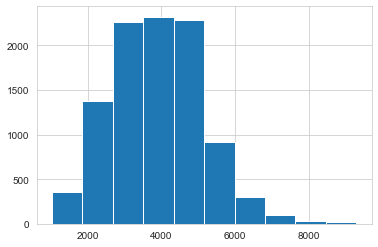

In [190]:
df = df.loc[(df['price_per_m2']>df['price_per_m2'].quantile(.001))&(df['price_per_m2']<df['price_per_m2'].quantile(.999))] 
df['price_per_m2'].hist()

In [191]:
df.drop('price_per_m2', axis=1, inplace=True)

#### KitchenSquare

In [192]:
df.loc[df['KitchenSquare']>100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1064,62,1,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,629,1,NaN,0,0,108337.484207,1,1,0,47.100719
2969,62,3,114.734473,112.589083,112.0,3,3.0,2015,0.072158,629,1,NaN,0,0,315245.521059,1,1,0,38.244824
4651,58,3,116.405693,113.109653,112.0,3,3.0,2016,0.437885,5735,3,1084.0,0,5,296165.936689,1,1,1,38.801898
8584,81,1,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,5285,0,645.0,6,6,105539.556275,1,1,1,32.276663
9895,27,3,125.806981,123.430072,123.0,5,10.0,2015,0.017647,469,0,NaN,0,0,234194.837047,1,1,1,41.143357


In [193]:
df.loc[df['KitchenSquare']>1000, 'KitchenSquare'] = round(df['KitchenSquare']/100)
df.loc[df['KitchenSquare']>150, 'KitchenSquare'] = round(df['KitchenSquare']/10)

In [194]:
test.loc[test['KitchenSquare']>100]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
1777,62,3,112.247841,112.114019,112.0,3,3.0,2017,0.072158,629,1,NaN,0,0,1,1,0,37.371340
1964,11,2,42.795304,24.223770,620.0,11,14.0,1972,0.038693,6533,1,1015.0,2,5,1,1,1,21.397652


In [195]:
test.loc[1964, 'KitchenSquare'] = test.loc[1964, 'KitchenSquare']/100

In [196]:
df['KitchenSquare_0'] = round(df['Square'] - df['LifeSquare'])
df.loc[(df['KitchenSquare_0']<0), 'KitchenSquare_0'] = 0
df.loc[(df['KitchenSquare']==0)&(df['KitchenSquare_0'].notnull()), 'KitchenSquare'] = df['KitchenSquare_0']
df.drop('KitchenSquare_0', axis=1, inplace=True)

In [197]:
test['KitchenSquare_0'] = round(test['Square'] - test['LifeSquare'])
test.loc[(test['KitchenSquare_0']<0), 'KitchenSquare_0'] = 0
test.loc[(test['KitchenSquare']==0)&(test['KitchenSquare_0'].notnull()), 'KitchenSquare'] = test['KitchenSquare_0']
test.drop('KitchenSquare_0', axis=1, inplace=True)

In [198]:
len(df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare']])

2468

In [199]:
len(test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare']])

1248

In [200]:
sq_minus=(df['Square'] - df['LifeSquare'] - df['KitchenSquare']).mean()

In [201]:
ks_m = round(df['KitchenSquare'].mean())
ks_m

6

Сделаем такое преобразование для этих квартир: поделим условно попалам, между колличеством комнат и кухни

In [202]:
df.loc[df['KitchenSquare']==0,'KitchenSquare'] = ks_m

In [203]:
test.loc[test['KitchenSquare']==0,'KitchenSquare'] = ks_m

In [204]:
df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare'], ['KitchenSquare', 'LifeSquare']] = [ks_m, df.loc[df['Square']+1<df['LifeSquare']+df['KitchenSquare'], 'Square'] -  ks_m - 1]


In [205]:
test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare'], ['KitchenSquare', 'LifeSquare']] = [ks_m, test.loc[test['Square']+1<test['LifeSquare']+test['KitchenSquare'], 'Square'] -  ks_m - 1]


In [206]:
df['KitchenSquare'] = df['KitchenSquare'].astype(int)
test['KitchenSquare'] = test['KitchenSquare'].astype(int)

#### Floor и HouseFloor. Конструирование признаков последнего и первого этажа

In [207]:
df['HouseFloor'] = df.HouseFloor.astype(int)
df['Floor_0'] = df['Floor']
df.loc[(df['HouseFloor']<df['Floor_0']), 'Floor'] = df.loc[(df['HouseFloor']<df['Floor']), 'HouseFloor'] 
df.loc[(df['HouseFloor']<df['Floor_0']), 'HouseFloor'] = df.loc[(df['HouseFloor']<df['Floor_0']), 'Floor_0']
df.drop('Floor_0', axis=1, inplace=True)

In [208]:
test['HouseFloor'] = test.HouseFloor.astype(int)
test['Floor_0'] = test['Floor']
test.loc[(test['HouseFloor']<test['Floor_0']), 'Floor'] = test.loc[(test['HouseFloor']<test['Floor']), 'HouseFloor'] 
test.loc[(test['HouseFloor']<test['Floor_0']), 'HouseFloor'] = test.loc[(test['HouseFloor']<test['Floor_0']), 'Floor_0']
test.drop('Floor_0', axis=1, inplace=True)

Мы знаем, что самый высокий дом в США 96 этажей

In [209]:
df.loc[df['HouseFloor']>96]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
6131,5,1,51.944587,48.709601,1,6,99,1977,0.150818,3433,4,2643.0,4,5,296127.115515,1,1,1,51.944587
8599,74,2,74.579809,67.579809,6,5,99,1977,0.075779,1437,3,NaN,0,2,243329.912579,1,1,1,35.873935
8854,30,2,66.811789,65.773749,1,8,117,1977,0.000078,6398,141,1046.0,3,23,207248.370520,1,1,1,32.886874


In [210]:
def mydel(S):
    S= str(S)
    for i in range(len(S)):
        new =S[:i]+S[i+1:]
    return int(new)
df.loc[df['HouseFloor']>96, 'HouseFloor'] = df.loc[df['HouseFloor']>96, 'HouseFloor'].apply(mydel)

In [211]:
test.loc[test['HouseFloor']>96]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room
651,27,3,47.722835,40.722835,6,18,99,1977,0.072158,629,1,NaN,0,0,1,1,0,15.907612


In [212]:
test.loc[651, ['Floor', 'HouseFloor']] = [9,18]

In [213]:
df['Last_floor'] = 0
df['Grand_floor'] = 0
df.loc[df['HouseFloor']==df['Floor'], 'Last_floor'] = 1
df.loc[df['Floor']==0, 'Grand_floor'] = 1

In [214]:
test['Last_floor'] = 0
test['Grand_floor'] = 0
test.loc[test['HouseFloor']==test['Floor'], 'Last_floor'] = 1
test.loc[test['Floor']==0, 'Grand_floor'] = 1

#### Healthcare_1
Видили небольшую корреляцию признака с DistrictId, используем это, чтобы заполнить пропуски.

In [215]:
data_pivot = df.pivot_table(index='DistrictId', values ='Healthcare_1',  aggfunc='mean')
healthcare_1_m = df['Healthcare_1'].mean()
data_pivot = data_pivot.reset_index()

In [216]:
b = data_pivot['DistrictId'].unique()

In [217]:
for d in df['DistrictId'].unique():
    if d not in b:
        data_pivot = data_pivot.append({'DistrictId': d,'Healthcare_1':healthcare_1_m}, ignore_index=True )     
    else:
        data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'] = (data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'] + healthcare_1_m)/2
len(data_pivot)

205

In [218]:
for d in df['DistrictId'].unique():
    dm = data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'].mean()
    df.loc[(df['Healthcare_1'].isnull())&(df['DistrictId'] == d), 'Healthcare_1'] = dm

In [219]:
for d in df['DistrictId'].unique():
    dm = data_pivot.loc[data_pivot['DistrictId'] == d, 'Healthcare_1'].mean()
    test.loc[(test['Healthcare_1'].isnull())&(test['DistrictId'] == d), 'Healthcare_1'] = dm

In [220]:
df_test = df.append(test, ignore_index=True)
df_test.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor
0,35,2,47.981561,29.442751,6,7,9,1969,0.089040,7976,...,1140.38362,0,11,184966.930730,1,1,1,23.990781,0,0
1,41,3,65.683640,40.049543,8,7,9,1978,0.000070,10309,...,240.00000,1,16,300009.450063,1,1,1,21.894547,0,0
2,53,2,44.947953,29.197612,16,8,12,1968,0.049637,7759,...,229.00000,1,3,220925.908524,1,1,1,22.473976,0,0
3,58,2,53.352981,46.352981,6,8,17,1977,0.437885,5735,...,1084.00000,0,5,175616.227217,1,1,1,26.676491,0,0
4,99,1,39.649192,23.776169,7,11,12,1976,0.012339,5776,...,2078.00000,2,4,150226.531644,1,1,1,39.649192,0,0


#### Конструирование признака district_size

In [221]:

district_size = df_test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df = df.merge(district_size, on='DistrictId', how='left')
test = test.merge(district_size, on='DistrictId', how='left')

df.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,...,Helthcare_2,Shops_1,Price,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize
0,35,2,47.981561,29.442751,6,7,9,1969,0.089040,7976,...,0,11,184966.930730,1,1,1,23.990781,0,0,36
1,41,3,65.683640,40.049543,8,7,9,1978,0.000070,10309,...,1,16,300009.450063,1,1,1,21.894547,0,0,131
2,53,2,44.947953,29.197612,16,8,12,1968,0.049637,7759,...,1,3,220925.908524,1,1,1,22.473976,0,0,265
3,58,2,53.352981,46.352981,6,8,17,1977,0.437885,5735,...,0,5,175616.227217,1,1,1,26.676491,0,0,270
4,99,1,39.649192,23.776169,7,11,12,1976,0.012339,5776,...,2,4,150226.531644,1,1,1,39.649192,0,0,139


#### Конструирование признака Distrikt_D

In [222]:
min_max = MinMaxScaler()
mask = ['Ecology_1','Social_2','Social_3','Healthcare_1','Helthcare_2','Shops_1']
min_max.fit(df_test[mask])
df_test[mask] = min_max.transform(df_test[mask])

df_test['Distrikt_D'] = (df_test['Ecology_1']+df_test['Social_2']+df_test['Social_3']+df_test['Healthcare_1']+df_test['Helthcare_2']+df_test['Shops_1'])/len(mask)
dis_d = df_test.groupby('DistrictId').mean().reset_index()[['DistrictId', 'Distrikt_D' ]]

df = df.merge(dis_d, on='DistrictId', how='left')
test = test.merge(dis_d, on='DistrictId', how='left')

## Распределение цены

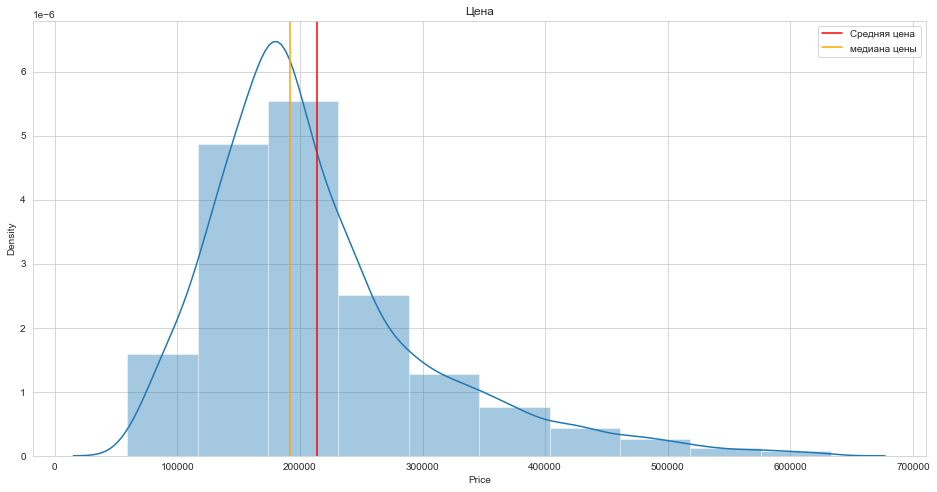

In [223]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins = 10)

plt.axvline(df['Price'].mean(), label='Средняя цена',  color = 'red')
plt.axvline(df['Price'].median(), label='медиана цены',  color = 'orange')


plt.title('Цена')
plt.legend()
plt.show()

In [224]:
def plot(x, y=None, title=None, x_label=None, y_label=None, kind='plot', **kwargs):
    f, n = {
        'plot': (plt.plot, 2),
        'line': (plt.plot, 2),
        'scatter': (plt.scatter, 2),
        'hist': (plt.hist, 1),
        'dist': (sns.distplot, 1),
        'box': (sns.boxplot, 1),
        'violin': (sns.violinplot, 1),
        'reg': (sns.regplot, 2),
        'lm': (sns.lmplot, 2),
    }[kind]
    f(x, **kwargs) if n == 1 else f(x, y, **kwargs)
    ax = kwargs['ax'] if 'ax' in kwargs else plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    return ax

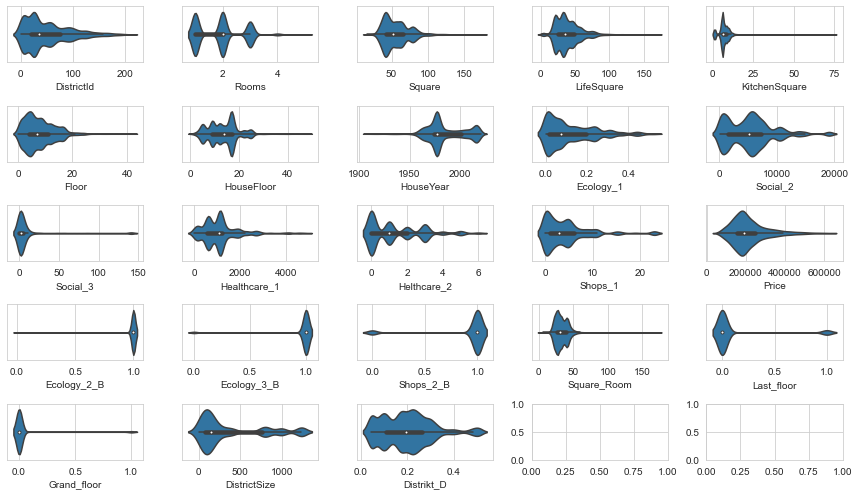

In [227]:
f, axs = plt.subplots(5, 5, figsize=(12, 7))
axs = axs.flatten()
for i, c in enumerate(df.columns):
    plot(df[c], x_label=c, kind='violin', ax=axs[i], orient='v')
plt.tight_layout()   

In [231]:
g = list(df.columns)
g.remove('Ecology_2_B')
g.remove('Ecology_3_B')
g.remove('Shops_2_B')
g

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Square_Room',
 'Last_floor',
 'Grand_floor',
 'DistrictSize',
 'Distrikt_D']

In [232]:
cols_to_log = g

log1p_boston = partial(log1p_columns, cols=cols_to_log)
expm1_boston = partial(expm1_columns, cols=cols_to_log)

In [233]:
# df = log1p_boston(df)

## Разделение на train, valid

In [234]:
train, valid = train_test_split(df, test_size=0.25, random_state = 12345)

## Конструирование признаков на train

In [235]:
train['price_per_m2'] = train['Price'] / train['Square'] 
m2 = train.groupby('DistrictId').mean().reset_index()[['DistrictId','price_per_m2']]

In [236]:
train.drop('price_per_m2', axis=1, inplace=True)

In [237]:
valid = valid.merge(m2, on='DistrictId', how='left')
train = train.merge(m2, on='DistrictId', how='left')
price_per_m2_m = train['price_per_m2'].mean()
valid.loc[valid['price_per_m2'].isnull()] = price_per_m2_m


In [238]:
train['Pprice'] = train['price_per_m2']*train['Square']

valid['Pprice'] = valid['price_per_m2']*valid['Square']

In [239]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,...,Ecology_2_B,Ecology_3_B,Shops_2_B,Square_Room,Last_floor,Grand_floor,DistrictSize,Distrikt_D,price_per_m2,Pprice
0,101,2,46.606298,29.882507,5,4,5,1960,0.225825,6558,...,0,1,1,23.303149,0,0,143,0.266632,4039.433531,188263.044090
1,1,1,48.060539,41.060539,6,1,1,1977,0.007122,264,...,1,1,1,48.060539,1,0,995,0.043222,3205.830286,154073.933023
2,121,2,45.250953,23.171747,6,10,14,1977,0.212515,3293,...,1,1,1,22.625477,0,0,36,0.260069,4748.496469,214873.991883
3,47,3,82.666612,45.938245,12,8,14,2009,0.197368,2423,...,1,1,1,27.555537,0,0,146,0.206132,4126.059516,341087.360782
4,27,3,84.274055,50.505379,8,7,9,1997,0.041116,14892,...,1,1,1,28.091352,0,0,1235,0.085014,2744.956537,231328.618903


In [240]:
mask = (list(train.columns))
mask.remove('Price')
mask.remove('price_per_m2')

In [241]:
y_train = train['Price']
X_train = train[mask]
y_valid = valid['Price']
X_valid = valid[mask]


In [242]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train[mask] = scaler.transform(X_train)
X_valid[mask] = scaler.transform(X_valid)

## Обучение модели и поиск с Bayesian Hyperparameter Optimization using Hyperopt

### Objective Function

In [297]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

N_FOLDS = 5

def objective_function_regression(estimator):
    r2_array = cross_val_score( estimator, X_train, y_train, cv= 3, n_jobs=-1, scoring = make_scorer(r2) )
    
    return  abs(1 - np.mean(r2_array))


### Domain Space

In [246]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [279]:
from sklearn.ensemble import GradientBoostingRegressor
from hyperopt import hp, fmin, tpe
from hyperopt.pyll import scope

# hyperopt object for 
# scope.define(GradientBoostingRegressor)

# search space
n_estimators  = hp.randint('n_estimators',1000) 
learning_rate = hp.loguniform('learning_rate',-3,1)
max_depth     = hp.randint('max_depth', 10)
max_features =  hp.randint('max_features',X_train.shape[1]-1)
min_samples_leaf = hp.randint('min_samples_leaf', 10)
                                       
# model / estimator to be optimized
est0 = (0.1, scope.GradientBoostingRegressor( n_estimators  = n_estimators + 1,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth + 1,
                                            max_features = max_features + 1,
                                            min_samples_leaf = min_samples_leaf + 1,
                                            random_state=42) 
        )

# search space
search_space_regression = hp.pchoice('estimator', [est0])

### Bayesian Optimization

In [274]:
from hyperopt import fmin
from sklearn.model_selection import cross_val_score
from sklearn.metrics.regression import mean_absolute_error as mae

In [298]:
best = fmin(
    fn= objective_function_regression,
    space= search_space_regression,
    algo = tpe.suggest, # This is the optimization algorithm hyperopt uses, a tree of parzen estimators
    max_evals = 20,
    verbose = 2  # The number of iterations
         )

print(best)

100%|███████| 20/20 [02:09<00:00,  6.50s/trial, best loss: 0.23401496935969401]
{'estimator': 0, 'learning_rate': 0.04999431119636293, 'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 2, 'n_estimators': 416}


In [299]:
# allocate
Regressor = GradientBoostingRegressor( learning_rate = best['learning_rate'],
                          max_depth = best['max_depth'],
                          max_features = best['max_features'],
                          min_samples_leaf = best['min_samples_leaf'],
                          n_estimators = best['n_estimators'],
                          random_state = 42
                                       )
# fit
Regressor.fit(X_train,y_train)

y_train_preds = Regressor.predict(X_train)
y_valid_preds = Regressor.predict(X_valid)

print("Train R2:\t" + str(round(r2(y_train, y_train_preds), 3)))
print("Test R2:\t" + str(round(r2(y_valid_preds, y_valid), 3)))


Train R2:	0.871
Test R2:	0.714


## Вывод
При поиске с помощью Hyperopt модель выдает хороший результат и непереучивается.